# 1. 二分类信息熵

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# 计算信息熵, 二分类只有2中场景,所以可以直接计算
def entropy(p):
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

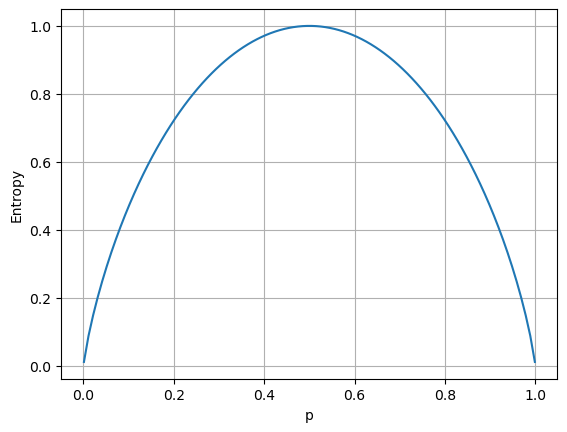

In [37]:
plot_x = np.linspace(0.001, 0.999, 100)
plt.plot(plot_x, entropy(plot_x))
plt.xlabel('p')
plt.ylabel('Entropy')
plt.grid()
plt.show()

可以看到当二分类问题概率p在0.5时,熵最大(就好比抛硬币,正反面概率一样,所以此时的结果是最不确定的)

# 2. 数据集

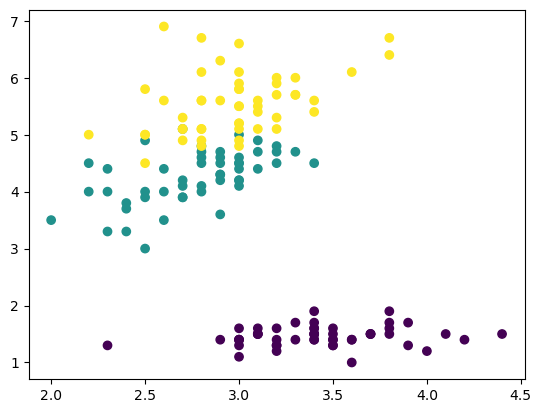

In [38]:
from sklearn.datasets import load_iris

iris = load_iris()
x = iris.data[:, 1:3] # 只取前两列特征
y = iris.target
plt.scatter(x[:,0], x[:,1], c = y) 
plt.show()

# 3. sklearn中的决策树

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
# 创建一个决策树分类器，设置最大深度为2，使用信息熵作为划分标准
clf = DecisionTreeClassifier(max_depth=2, criterion='entropy')
clf.fit(x, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [41]:
def decision_boundary_plot(X, y, clf):
    # 计算特征1和特征2的取值范围，并适当扩展边界
    axis_x1_min, axis_x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    axis_x2_min, axis_x2_max = X[:,1].min() - 1, X[:,1].max() + 1

    # 生成网格采样点，用于绘制决策边界
    x1, x2 = np.meshgrid(
        np.arange(axis_x1_min, axis_x1_max, 0.01),
        np.arange(axis_x2_min, axis_x2_max, 0.01)
    )

    # 将网格点坐标合并为特征输入，使用分类器预测每个点的类别
    z = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    # 将预测结果还原为网格形状
    z = z.reshape(x1.shape)

    # 导入自定义颜色映射
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#F5B9EF', '#BBFFBB', '#F9F9CB'])

    # 绘制决策边界的填充等高线图
    plt.contourf(x1, x2, z, cmap=custom_cmap)
    # 绘制原始数据点，按类别着色
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

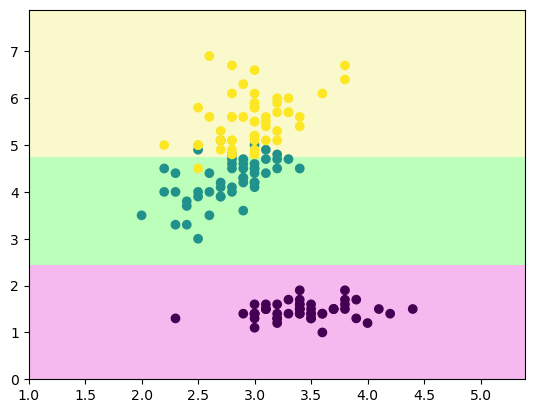

In [42]:
decision_boundary_plot(x, y, clf)

[Text(0.4, 0.8333333333333334, 'x[1] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 4.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.154\nsamples = 45\nvalue = [0, 44, 1]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.497\nsamples = 55\nvalue = [0, 6, 49]')]

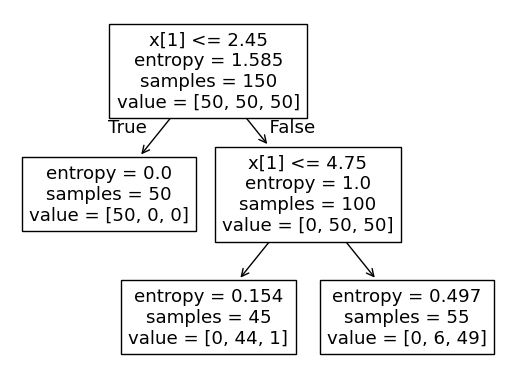

In [43]:
from sklearn.tree import plot_tree
plot_tree(clf)

# 4. 自主实现最优划分条件

In [44]:
from collections import Counter
Counter(y)

Counter({np.int64(0): 50, np.int64(1): 50, np.int64(2): 50})

In [45]:
# 计算整体的信息熵
def calc_entropy(y):
    counter = Counter(y)
    sum_ent = 0
    for i in counter:
        p = counter[i] / len(y)  # 当前类型的概率 = 当前类别的数量/总数量
        sum_ent += (-p * np.log2(p)) # 计算信息熵
    return sum_ent

In [46]:
calc_entropy(y)

np.float64(1.584962500721156)

In [47]:
x[x[:,1]<1.1]

array([[3.6, 1. ]])

In [48]:
x[:,1]<1.1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [49]:
x.shape[1]

2

In [50]:
def split_dataset(x, y, dim, value):
    """
    根据指定特征和阈值划分数据集
    参数:
        x (np.ndarray): 特征数据
        y (np.ndarray): 标签数据
        dim (int): 用于划分的特征索引
        value (float): 用于划分的特征阈值
    返回: 划分为两部分的数据集
    """
    index_left = (x[:, dim] <= value)
    index_right = (x[:, dim] > value)
    return x[index_left], y[index_left], x[index_right], y[index_right]

In [51]:
def find_best_split(x, y):
    best_dim = -1 # 最佳划分特征
    best_value = -1 # 最佳划分值
    best_entropy = np.inf  # 最佳划分熵
    best_entropy_left, best_entropy_right = -1, -1 # 左右子树的熵
    for dim in range(x.shape[1]):
        sorted_index = np.argsort(x[:, dim])
        for i in range(x.shape[0] - 1):
            # x[sorted_index[i], dim] 表示排序后第i个样本在dim特征上的值
            value_left,value_right = x[sorted_index[i], dim],x[sorted_index[i + 1], dim]
            if value_left != value_right:
                value = (value_left + value_right) / 2
                x_left, y_left, x_right, y_right = split_dataset(x, y, dim, value)
                # 计算左右子集的信息熵
                entropy_left, entropy_right = calc_entropy(y_left), calc_entropy(y_right)
                # 计算当前划分的整体信息熵
                entropy = (len(x_left) * entropy_left + len(x_right) * entropy_right) / x.shape[0]
                if entropy < best_entropy:
                    best_dim = dim
                    best_value = value
                    best_entropy = entropy
                    best_entropy_left, best_entropy_right = entropy_left, entropy_right
    return best_dim, best_value, best_entropy, best_entropy_left, best_entropy_right
            

In [52]:
find_best_split(x, y)

(1,
 np.float64(2.45),
 np.float64(0.6666666666666666),
 np.float64(0.0),
 np.float64(1.0))

In [53]:
x_left, y_left, x_right, y_right = split_dataset(x, y, 1, 2.45)

In [54]:
find_best_split(x_right, y_right)

(1,
 np.float64(4.75),
 np.float64(0.34262624992678425),
 np.float64(0.15374218032876188),
 np.float64(0.4971677614160753))